# Binning demonstration on locally generated fake data
In this example, we generate a table with random data simulating a single event dataset.
We showcase the binning method, first on a simple single table using the bin_partition method and then in the distributed method bin_dataframe, using daks dataframes.
The first method is never really called directly, as it is simply the function called by the bin_dataframe on each partition of the dask dataframe.

In [1]:
import sys

import dask
import numpy as np
import pandas as pd
import dask.dataframe

import matplotlib.pyplot as plt

sys.path.append("../")
from sed.binning import bin_partition, bin_dataframe

## Generate Fake Data

In [2]:
n_pts = 100000
cols = ["posx", "posy", "energy"]
df = pd.DataFrame(np.random.randn(n_pts, len(cols)), columns=cols)
df

,posx,posy,energy
0,-0.268954,-0.380589,-0.194257
1,-0.166491,0.219649,-1.598014
2,2.028135,-1.117243,0.054602
3,1.778971,-0.582201,-0.211374
4,-0.620210,-0.511628,-0.220653
...,...,...,...
99995,0.153227,0.287072,-1.799589
99996,0.643242,1.085360,0.558482
99997,-2.239366,1.157226,-0.352028
99998,1.666869,-0.558343,-0.143787


## Define the binning range

In [3]:
binAxes = ["posx", "posy", "energy"]
nBins = [120, 120, 120]
binRanges = [(-2, 2), (-2, 2), (-2, 2)]
coords = {ax: np.linspace(r[0], r[1], n) for ax, r, n in zip(binAxes, binRanges, nBins)}

## Compute the binning along the pandas dataframe

In [4]:
%%time
res = bin_partition(
    part=df,
    bins=nBins,
    axes=binAxes,
    ranges=binRanges,
    hist_mode="numba",
)

CPU times: user 1.31 s, sys: 45.2 ms, total: 1.36 s
Wall time: 1.54 s


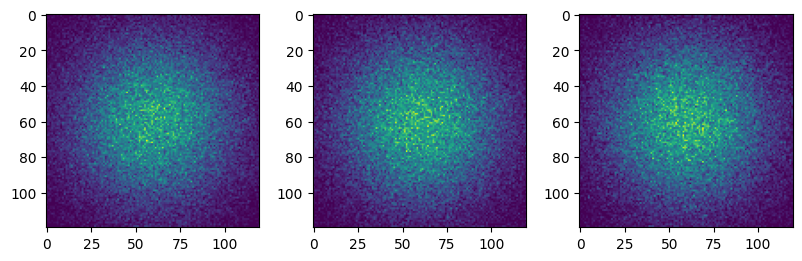

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), constrained_layout=True)
for i in range(3):
    axs[i].imshow(res.sum(i))

## Transform to dask dataframe

In [6]:
ddf = dask.dataframe.from_pandas(df, npartitions=50)
ddf

,posx,posy,energy
npartitions=50,,,
0,float64,float64,float64
2000,...,...,...
...,...,...,...
98000,...,...,...
99999,...,...,...


## Compute distributed binning on the partitioned dask dataframe
In this example, the small dataset does not give significant improvement over the pandas implementation, at least using this number of partitions.
A single partition would be faster (you can try...) but we use multiple for demonstration purposes.

In [7]:
%%time
res = bin_dataframe(
    df=ddf,
    bins=nBins,
    axes=binAxes,
    ranges=binRanges,
    hist_mode="numba",
)

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 417 ms, sys: 595 ms, total: 1.01 s
Wall time: 563 ms


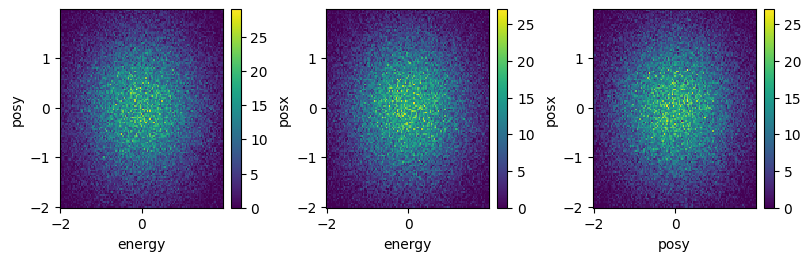

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), constrained_layout=True)
for dim, ax in zip(binAxes, axs):
    res.sum(dim).plot(ax=ax)